# Calculate effective reproduction number $R_e$

In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# IMPORT_HUMANS_PATH = '../outputs/humans_infected_time_course.csv'
IMPORT_HUMANS_PATH = '../outputs/humans_infected_time_course_basic_scenario.csv'

In [3]:
%%time
humans = pd.read_csv(IMPORT_HUMANS_PATH, sep = ';')

Wall time: 17.2 s


In [4]:
humans.head()

,h_ID,loc,status,WasInfected,Diagnosed,Hospitalized,ICUed,time,place_of_infection,infection_time,infected_by
0,14298,4779,S,0,0,0,0,0,NaN,NaN,NaN
1,12027,4031,S,0,0,0,0,0,NaN,NaN,NaN
2,4033,1335,S,0,0,0,0,0,NaN,NaN,NaN
3,14300,4779,S,0,0,0,0,0,NaN,NaN,NaN
4,12032,4033,S,0,0,0,0,0,NaN,NaN,NaN


In [5]:
humans.shape

(30050000, 11)

We can only thoroughly calculate $R_e$ from closed cases (`R` and `D`).

In [6]:
closed_IDs = np.unique(humans[humans.status.isin(['R', 'D'])].h_ID.values)
closed_IDs

array([    1,     2,     3, ..., 15023, 15024, 15025], dtype=int64)

In [7]:
closed_ID = closed_IDs[0]
closed_ID

1

How many humans were infected by `closed_ID`:

In [8]:
humans[humans.infected_by == closed_ID]['infected_by'].count()

0

Superspreaders list:

In [12]:
humans[humans.infected_by.isin(closed_IDs)].groupby('infected_by').count().h_ID.sort_values(ascending = False)

infected_by
10643.0    9
8547.0     8
13283.0    8
857.0      8
13495.0    8
          ..
8506.0     1
8508.0     1
8509.0     1
8511.0     1
2.0        1
Name: h_ID, Length: 7688, dtype: int64

Spread statistics:

In [13]:
humans[humans.infected_by.isin(closed_IDs)].groupby('infected_by').count().h_ID.describe()

count    7688.000000
mean        1.773933
std         1.072565
min         1.000000
25%         1.000000
50%         1.000000
75%         2.000000
max         9.000000
Name: h_ID, dtype: float64

Effective reproduction number $R_e$:

In [14]:
humans[humans.infected_by.isin(closed_IDs)].groupby('infected_by').count().h_ID.mean()

1.7739334027055151

Wrap all of this into a function:

In [15]:
def effective_reproduction_number(humans):
    closed_IDs = np.unique(humans[humans.status.isin(['R', 'D'])].h_ID.values)
    r_e = humans[humans.infected_by.isin(closed_IDs)].groupby('infected_by').count().h_ID.mean()
    
    return r_e

In [17]:
%%time
effective_reproduction_number(humans)

Wall time: 6.3 s


1.7739334027055151

Condition on time; only allow infections that happened at or after `time`:

In [18]:
def effective_reproduction_number_conditional(humans, time):
    closed_IDs = np.unique(humans[humans.status.isin(['R', 'D'])].h_ID.values)
    
    relevant_humans = humans[humans.infection_time >= time]
    r_e = relevant_humans[relevant_humans.infected_by.isin(closed_IDs)].groupby('infected_by').count().h_ID.mean()
    
    return r_e

In [19]:
%%time
effective_reproduction_number_conditional(humans, 200)

Wall time: 3.13 s


1.7681669928245272

Latest time in table:

In [21]:
humans.infection_time.max()

1220.0

In [64]:
def effective_reproduction_number_conditional_window(humans, time, window_size):
    maxtime = humans.infection_time.max()
    
    if time + window_size > maxtime:
        print('Time window extends past maximum time in dataframe, returning NaN.')
        return np.NaN

    closed_IDs = np.unique(humans[humans.status.isin(['R', 'D'])].h_ID.values)
    
    relevant_humans = humans[(humans.infection_time >= time) & (humans.infection_time < time + window_size)]
    r_e = relevant_humans[relevant_humans.infected_by.isin(closed_IDs)].groupby('infected_by').count().h_ID.mean()
    
    return r_e

One week:

In [72]:
window_size = 7 * 24

In [66]:
%%time
effective_reproduction_number_conditional_window(humans, time = 200, window_size = week)

Wall time: 3.42 s


2.129129129129129

In [67]:
xs = np.arange(0, 1200, 25)

In [68]:
%%time
ys = [effective_reproduction_number_conditional_window(humans, time = x, window_size = window_size) for x in xs]

Time window extends past maximum time in dataframe, returning NaN.
Time window extends past maximum time in dataframe, returning NaN.
Time window extends past maximum time in dataframe, returning NaN.
Time window extends past maximum time in dataframe, returning NaN.
Time window extends past maximum time in dataframe, returning NaN.
Wall time: 2min 26s


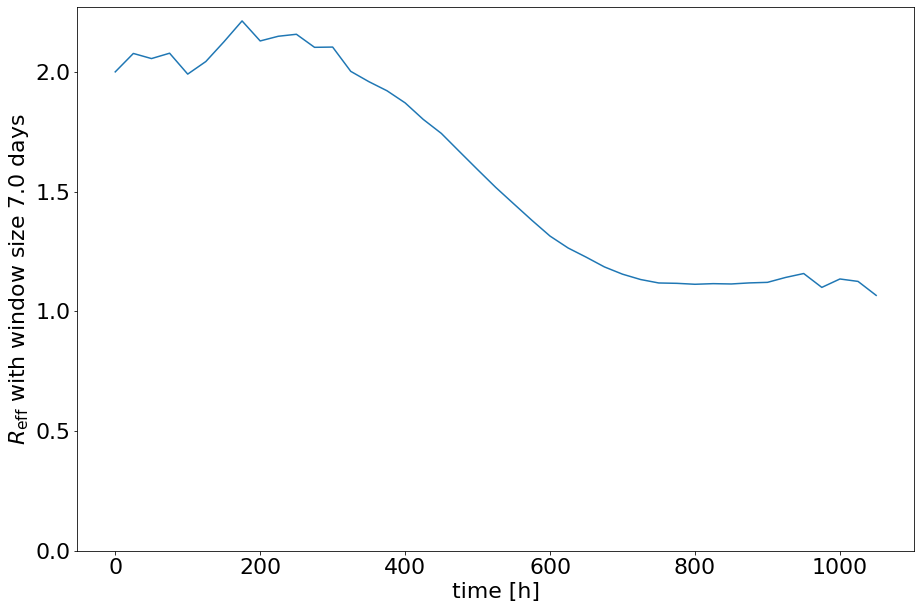

In [76]:
fig = plt.figure(figsize = (15, 10))

plt.rcParams.update({'font.size': 22})
plt.plot(xs, ys)
fig.gca().set_ylim(bottom = 0) # start y axis at 0

plt.xlabel("time [h]")
plt.ylabel(f"$R_\mathrm{{eff}}$ with window size {window_size / 24} days")

plt.show()